#Reading Data

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 28 03:37:43 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
######################################
#Import images from Google Drive to Colab
######################################
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
import os
import sys
os.chdir('/content/gdrive/MyDrive/ThesisData')
sys.path.append("/content/gdrive/MyDrive/ThesisData")
!pwd

/content/gdrive/MyDrive/ThesisData


#Import Library

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50, ResNet152

#Image Preprocessing

In [8]:
# Defime image size
imgWidth = 224
imgHeight = 224
# Batch size
batch_size = 128

In [9]:
# image preprocessing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = "../ThesisData"

training_set = train_datagen.flow_from_directory(base_dir+'/train',
                                                 target_size=(imgWidth, imgHeight),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(base_dir+'/val',
                                            target_size=(imgWidth, imgHeight),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

test_set = test_datagen.flow_from_directory(base_dir+'/test',
                                            target_size=(imgWidth, imgHeight),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)



Found 10024 images belonging to 10 classes.
Found 1253 images belonging to 10 classes.
Found 1253 images belonging to 10 classes.


In [10]:
train_num = training_set.samples
valid_num = valid_set.samples

In [11]:
num_classes = 10
input_shape = (imgHeight, imgWidth , 3)

#ResNet Architecture Overview:
The architecture of ResNet50 is divided into four main parts: The convolutional layers, the identity block, the convolutional block, and the fully connected layers.
* The convolutional layers are responsible for extracting features from the input image.
* The identity block and convolutional block are responsible for processing and transforming these features.
* Finally, the fully connected layers are used to make the final classification.


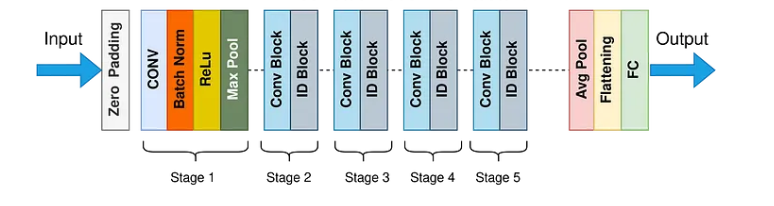

In [ ]:
from IPython import display
display.Image("/content/gdrive/MyDrive/ThesisData/TheoryImages/ResNet_Architectures.png")

It is using Skip connection/ Resual connection:



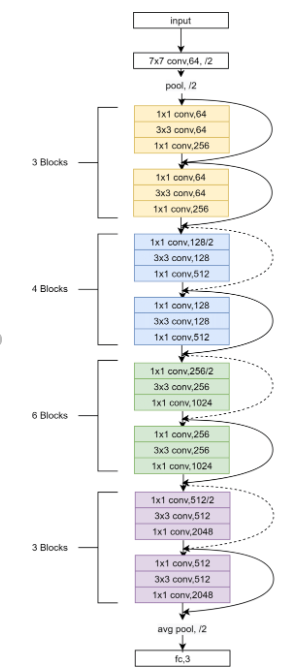

In [ ]:
from IPython import display
display.Image("/content/gdrive/MyDrive/ThesisData/TheoryImages/ResNet50_Architecture.png")

Layers in ResNet:

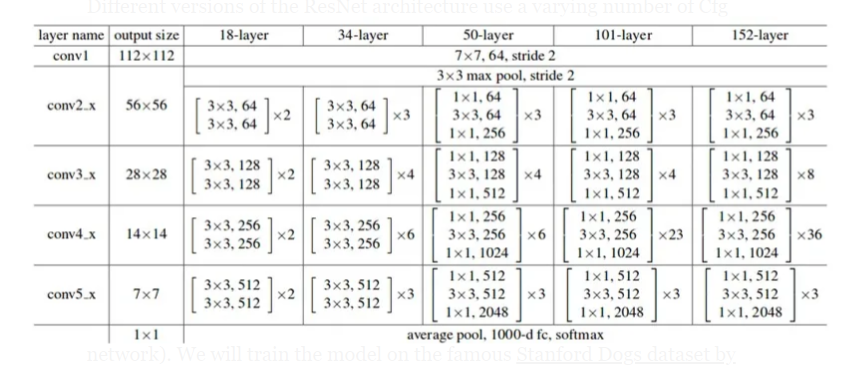

In [ ]:
from IPython import display
display.Image("/content/gdrive/MyDrive/ThesisData/TheoryImages/ResNet_Layers.png")

#ResNet50 Model

##Train Model

In [ ]:
def build_model(ResNet, input_shape):
    inp = Input(shape=input_shape)
    resnet = ResNet(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    # freeze ResNet
    resnet.trainable = False
    x = resnet(inp)
   
    x =  Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    model.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    
    return model


resnet50 = build_model(ResNet50, input_shape)
resnet50.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 10)                1003530   
                                                                 
Total params: 24591242 (93.81 MB)
Trainable params: 1003530 (3.83 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
import pickle

#fitting images to resnet
history = resnet50.fit(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=25,
                         validation_steps=valid_num//batch_size)
#saving model
resnet50.save("ResNet50.hdf5")


# Save the training history to a file using pickle
with open('ResNet50_History.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/25
78/78 [==============================] - 6837s 88s/step - loss: 4.7684 - accuracy: 0.1731 - val_loss: 2.1784 - val_accuracy: 0.2109
Epoch 2/25
78/78 [==============================] - 186s 2s/step - loss: 2.0869 - accuracy: 0.2520 - val_loss: 1.8754 - val_accuracy: 0.3229
Epoch 3/25
78/78 [==============================] - 184s 2s/step - loss: 2.0943 - accuracy: 0.2668 - val_loss: 1.9965 - val_accuracy: 0.2760
Epoch 4/25
78/78 [==============================] - 183s 2s/step - loss: 1.9816 - accuracy: 0.3040 - val_loss: 1.8165 - val_accuracy: 0.3854
Epoch 5/25
78/78 [==============================] - 180s 2s/step - loss: 1.9934 - accuracy: 0.3193 - val_loss: 1.8704 - val_accuracy: 0.3351
Epoch 6/25
78/78 [==============================] - 181s 2s/step - loss: 1.8991 - accuracy: 0.3394 - val_loss: 1.7087 - val_accuracy: 0.3950
Epoch 7/25
78/78 [==============================] - 182s 2s/step - loss: 2.2779 - accuracy: 0.3073 - val_loss: 1.7736 - val_accuracy: 0.4184
Epoch 8/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Print Metrics

In [21]:
# from keras.models import load_model
# from keras.utils import CustomObjectScope

# #Load model from a saved model file
# resnet50 = load_model('/content/gdrive/MyDrive/ThesisData/ResNet50.hdf5')

In [22]:
from time import time
start = time()
evl = resnet50.evaluate(test_set)
test_time = time() - start

test_loss, test_acc = evl[0]*100, evl[1]*100

msg = f'Test Accuracy = {test_acc:5.2f} %'
msg1 = f'Test Loss = {test_loss:5.2f} %'
msg2 = f'Test Time = {test_time:5.2f} s'
print(msg)
print(msg1)
print(msg2)

10/10 [==============================] - 7s 614ms/step - loss: 1.5175 - accuracy: 0.4916
Test Accuracy = 49.16 %
Test Loss = 151.75 %
Test Time =  8.02 s


In [23]:
from sklearn.metrics import classification_report
# Make predictions on the test set
predicted_labels = resnet50.predict(test_set)
# Convert predicted probabilities to class labels (if necessary)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Calculate classification report
report = classification_report(test_set.labels, predicted_classes)
print(report)

10/10 [==============================] - 9s 805ms/step
              precision    recall  f1-score   support

           0       0.49      0.64      0.56       132
           1       0.41      0.82      0.55       124
           2       0.31      0.83      0.45       124
           3       0.83      0.75      0.79       125
           4       0.38      0.69      0.49       124
           5       0.95      0.72      0.82       125
           6       1.00      0.08      0.15       124
           7       0.87      0.16      0.27       126
           8       0.94      0.12      0.21       124
           9       0.92      0.09      0.16       125

    accuracy                           0.49      1253
   macro avg       0.71      0.49      0.44      1253
weighted avg       0.71      0.49      0.45      1253



In [ ]:
# Access the mean accuracy and loss of training from the history object
mean_accuracy = np.average(history.history['accuracy'])
mean_loss = np.average(history.history['loss'])

print("Training - Average Accuracy:", mean_accuracy)
print("Training - Average Loss:", mean_loss)

# Access the average accuracy and loss of validation from the history object
mean_accuracyVal = np.average(history.history['val_accuracy'])
mean_lossVal = np.average(history.history['val_loss'])

print("Validation - Average Accuracy:", mean_accuracyVal)
print("Validation - Average Loss:", mean_lossVal)

Training - Average Accuracy: 0.3772635406255722
Training - Average Loss: 1.9259447479248046
Validation - Average Accuracy: 0.42329861044883726
Validation - Average Loss: 1.738795084953308


##Visualising Training Progress

Training accuracy: [0.17310024797916412, 0.25202101469039917, 0.266774445772171, 0.3039611876010895, 0.319320946931839, 0.3394300639629364, 0.30729588866233826, 0.3581244945526123, 0.3609539270401001, 0.3571139872074127, 0.36782538890838623, 0.38035568594932556, 0.3928860127925873, 0.4039005637168884, 0.4041026532649994, 0.42067500948905945, 0.43320533633232117, 0.4184519052505493, 0.42663702368736267, 0.4422999322414398, 0.46877527236938477, 0.45280921459198, 0.4465440511703491, 0.4542239308357239, 0.4808003306388855]
Validation accuracy: [0.2109375, 0.3229166567325592, 0.2760416567325592, 0.3854166567325592, 0.3350694477558136, 0.3949652910232544, 0.4184027910232544, 0.3689236044883728, 0.3559027910232544, 0.4557291567325592, 0.3472222089767456, 0.4774305522441864, 0.5147569179534912, 0.359375, 0.4748263955116272, 0.4071180522441864, 0.4739583432674408, 0.5026041865348816, 0.4965277910232544, 0.5104166865348816, 0.4800347089767456, 0.5034722089767456, 0.5130208134651184, 0.5199652910

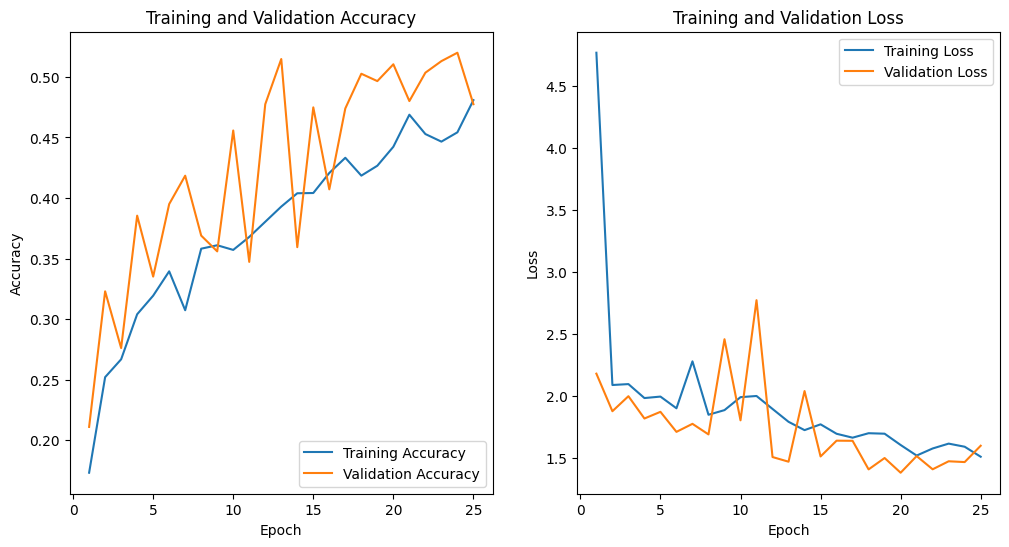

In [ ]:
################################
# Visualize the loss and accuracy
###############################
#accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy:", acc)
print("Validation accuracy:", val_acc)

#loss accuracy and validation loss accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training loss:", loss)
print("Validation loss:", val_loss)

epochs = range(1, len(loss) + 1)

#Plot Training Accuracy and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#Plot Training Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('ResNet50.png')
plt.show()

In [24]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

True :  [0 0 0 ... 9 9 9]
10/10 [==============================] - 8s 766ms/step
Predicted :  [4 4 2 ... 9 4 4]


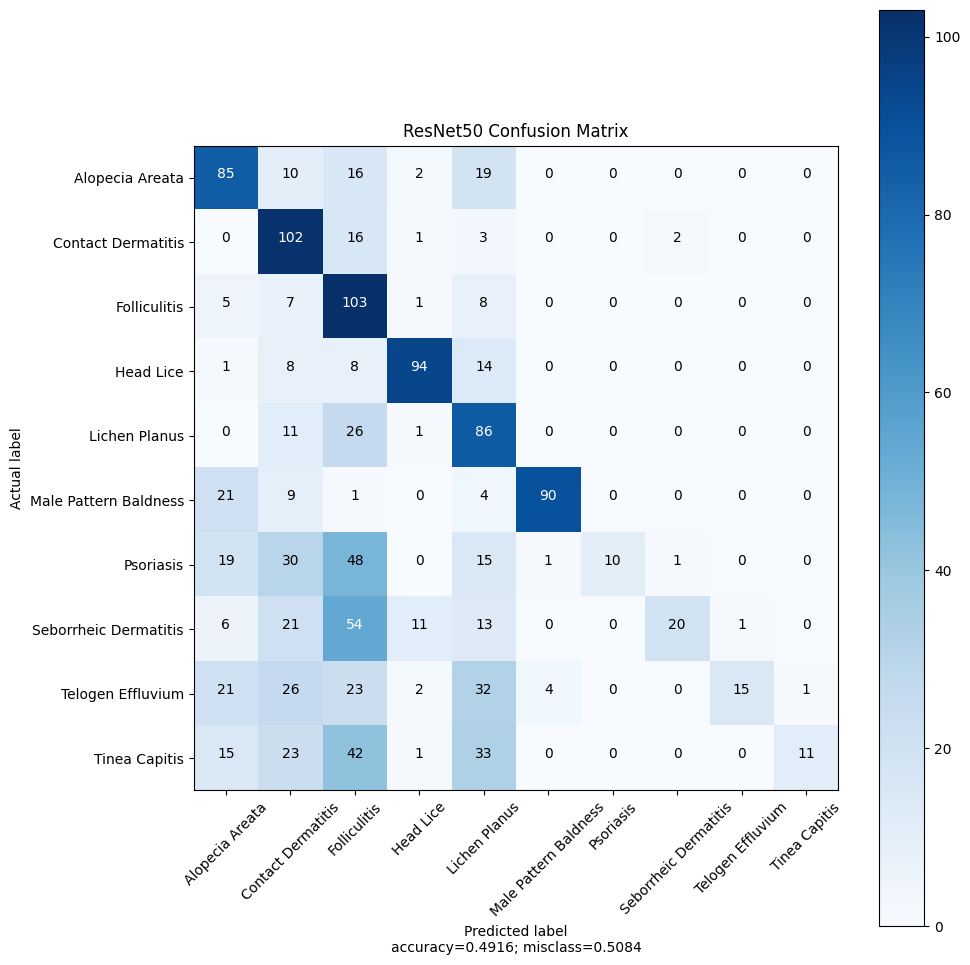

In [25]:
from sklearn.metrics import confusion_matrix

classes = ['Alopecia Areata', 'Contact Dermatitis', 'Folliculitis', 'Head Lice', 'Lichen Planus', 'Male Pattern Baldness', 'Psoriasis', 'Seborrheic Dermatitis', 'Telogen Effluvium', 'Tinea Capitis']

y_true = np.array(test_set.labels)
print("True : ", y_true)

y_pred = resnet50.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print("Predicted : ", y_pred)

conf_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = conf_mat,
                      normalize    = False,
                      target_names = classes,
                      title        = "ResNet50 Confusion Matrix")

#ResNet152 Model

##Train Model

In [ ]:
def build_model(ResNet, input_shape):
    inp = Input(shape=input_shape)
    resnet = ResNet(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    # freeze ResNet
    resnet.trainable = False
    x = resnet(inp)
 
    x =  Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    model.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model


resnet152 = build_model(ResNet152, input_shape)
resnet152.summary()

234698864/234698864 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 10)                1003530   
                                                                 
Total params: 59374474 (226.50 MB)
Trainable params: 1003530 (3.83 MB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [ ]:
import pickle

#fitting images to AlexNet
history = resnet152.fit(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=10,
                         validation_steps=valid_num//batch_size)
#saving model
resnet152.save("ResNet152.hdf5")


# Save the training history to a file using pickle
with open('ResNet152_History.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/10
78/78 [==============================] - 200s 3s/step - loss: 1.9792 - accuracy: 0.3018 - val_loss: 1.9853 - val_accuracy: 0.3290
Epoch 2/10
78/78 [==============================] - 197s 3s/step - loss: 2.0032 - accuracy: 0.3143 - val_loss: 1.7829 - val_accuracy: 0.3507
Epoch 3/10
78/78 [==============================] - 198s 3s/step - loss: 1.8607 - accuracy: 0.3492 - val_loss: 1.9161 - val_accuracy: 0.3385
Epoch 4/10
78/78 [==============================] - 229s 3s/step - loss: 1.8399 - accuracy: 0.3509 - val_loss: 1.8501 - val_accuracy: 0.3819
Epoch 5/10
78/78 [==============================] - 201s 3s/step - loss: 1.8678 - accuracy: 0.3593 - val_loss: 1.8960 - val_accuracy: 0.3950
Epoch 6/10
78/78 [==============================] - 197s 3s/step - loss: 1.8108 - accuracy: 0.3644 - val_loss: 1.7048 - val_accuracy: 0.3863
Epoch 7/10
78/78 [==============================] - 197s 3s/step - loss: 1.8597 - accuracy: 0.3605 - val_loss: 1.5468 - val_accuracy: 0.4748
Epoch 8/10
78

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Print Metrics

In [17]:
# from keras.models import load_model
# from keras.utils import CustomObjectScope

# #Load model from a saved model file
# resnet152 = load_model('/content/gdrive/MyDrive/ThesisData/ResNet152.hdf5')

In [15]:
from time import time
start = time()
evl = resnet152.evaluate(test_set)
test_time = time() - start

test_loss, test_acc = evl[0]*100, evl[1]*100

msg = f'Test Accuracy = {test_acc:5.2f} %'
msg1 = f'Test Loss = {test_loss:5.2f} %'
msg2 = f'Test Time = {test_time:5.2f} s'
print(msg)
print(msg1)
print(msg2)

10/10 [==============================] - 825s 90s/step - loss: 1.8154 - accuracy: 0.3687
Test Accuracy = 36.87 %
Test Loss = 181.54 %
Test Time = 967.75 s


In [18]:
from sklearn.metrics import classification_report
# Make predictions on the test set
predicted_labels = resnet152.predict(test_set)
# Convert predicted probabilities to class labels (if necessary)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Calculate classification report
report = classification_report(test_set.labels, predicted_classes)
print(report)

10/10 [==============================] - 11s 881ms/step
              precision    recall  f1-score   support

           0       0.60      0.26      0.36       132
           1       0.94      0.40      0.56       124
           2       0.86      0.25      0.39       124
           3       1.00      0.38      0.55       125
           4       1.00      0.05      0.09       124
           5       0.66      0.86      0.75       125
           6       0.15      0.92      0.26       124
           7       0.43      0.36      0.39       126
           8       0.64      0.15      0.24       124
           9       0.90      0.07      0.13       125

    accuracy                           0.37      1253
   macro avg       0.72      0.37      0.37      1253
weighted avg       0.72      0.37      0.37      1253



In [ ]:
# Access the mean accuracy and loss of training from the history object
mean_accuracy = np.average(history.history['accuracy'])
mean_loss = np.average(history.history['loss'])

print("Training - Average Accuracy:", mean_accuracy)
print("Training - Average Loss:", mean_loss)

# Access the average accuracy and loss of validation from the history object
mean_accuracyVal = np.average(history.history['val_accuracy'])
mean_lossVal = np.average(history.history['val_loss'])

print("Validation - Average Accuracy:", mean_accuracyVal)
print("Validation - Average Loss:", mean_lossVal)

Training - Average Accuracy: 0.35849838256835936
Training - Average Loss: 1.8501980304718018
Validation - Average Accuracy: 0.39157986342906953
Validation - Average Loss: 1.777525544166565


##Visualising Training Progress

Training accuracy: [0.30183911323547363, 0.3142683804035187, 0.349232017993927, 0.35094988346099854, 0.35933709144592285, 0.36438965797424316, 0.3605497181415558, 0.3923807740211487, 0.3978375196456909, 0.3941996693611145]
Validation accuracy: [0.3289930522441864, 0.3506944477558136, 0.3385416567325592, 0.3819444477558136, 0.3949652910232544, 0.3862847089767456, 0.4748263955116272, 0.4418402910232544, 0.4513888955116272, 0.3663194477558136]
Training loss: [1.9791640043258667, 2.0031771659851074, 1.8606505393981934, 1.8399345874786377, 1.8677622079849243, 1.8107657432556152, 1.8596813678741455, 1.777439832687378, 1.7486478090286255, 1.754757046699524]
Validation loss: [1.9853324890136719, 1.7828782796859741, 1.9161105155944824, 1.8500537872314453, 1.8960446119308472, 1.70475435256958, 1.5467711687088013, 1.6704826354980469, 1.584157109260559, 1.8386704921722412]


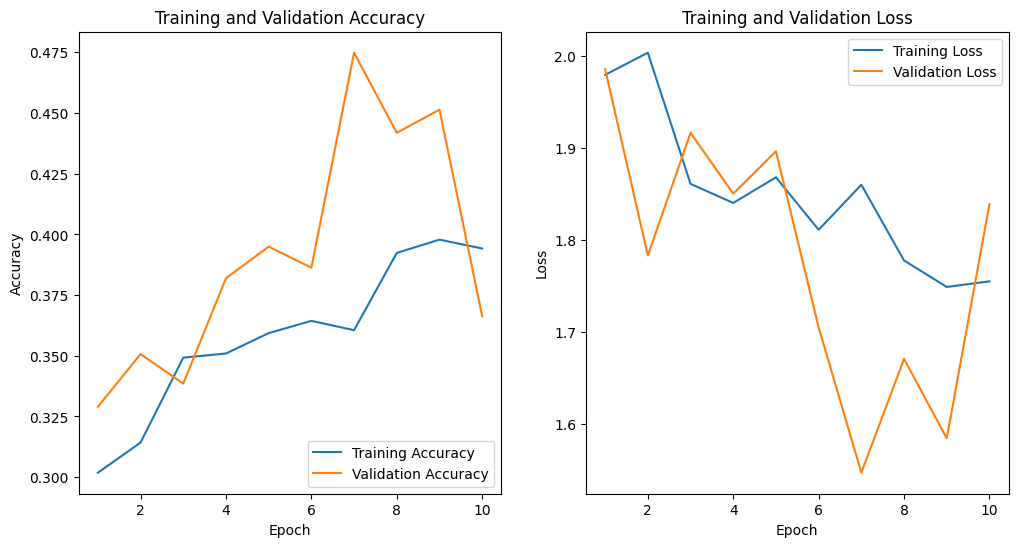

In [ ]:
################################
# Visualize the loss and accuracy
###############################
#accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy:", acc)
print("Validation accuracy:", val_acc)

#loss accuracy and validation loss accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training loss:", loss)
print("Validation loss:", val_loss)

epochs = range(1, len(loss) + 1)

#Plot Training Accuracy and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#Plot Training Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('ResNet152.png')
plt.show()

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

True :  [0 0 0 ... 9 9 9]
10/10 [==============================] - 9s 940ms/step
Predicted :  [6 6 6 ... 9 6 6]


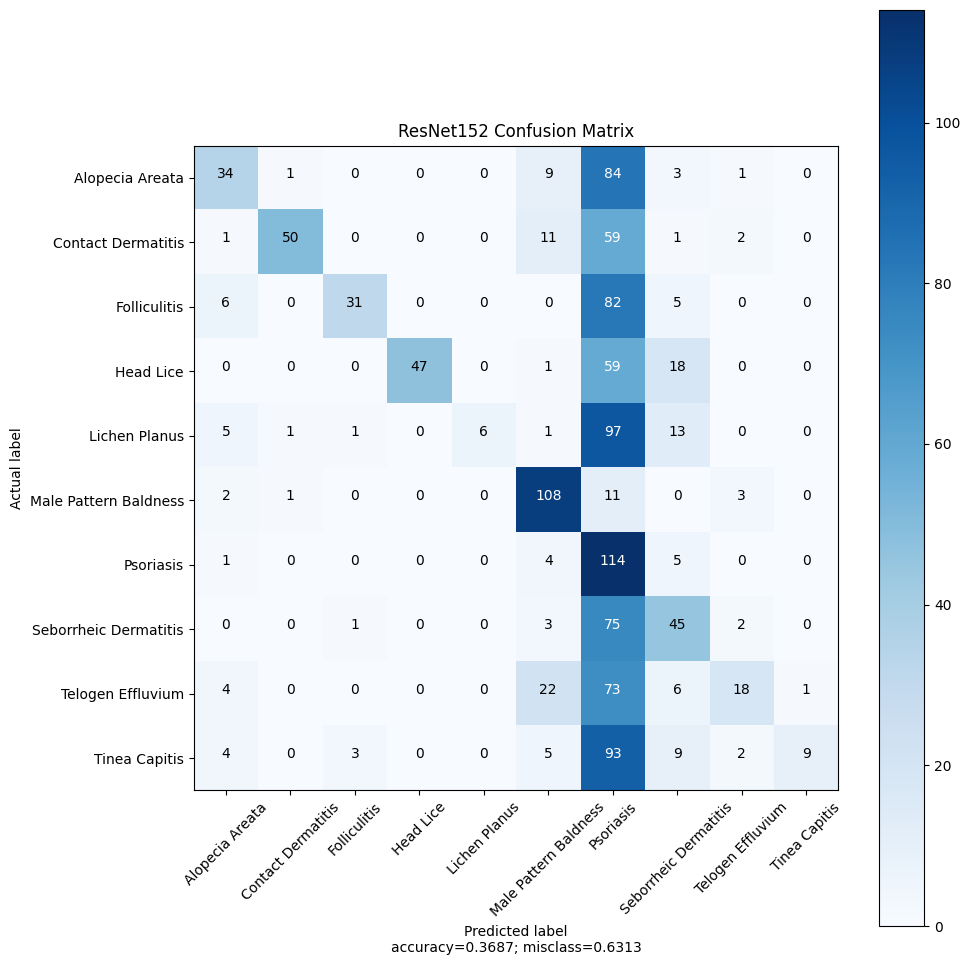

In [20]:
from sklearn.metrics import confusion_matrix

classes = ['Alopecia Areata', 'Contact Dermatitis', 'Folliculitis', 'Head Lice', 'Lichen Planus', 'Male Pattern Baldness', 'Psoriasis', 'Seborrheic Dermatitis', 'Telogen Effluvium', 'Tinea Capitis']

y_true = np.array(test_set.labels)
print("True : ", y_true)

y_pred = resnet152.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print("Predicted : ", y_pred)

conf_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = conf_mat,
                      normalize    = False,
                      target_names = classes,
                      title        = "ResNet152 Confusion Matrix")